In [1]:
# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [2]:
from datetime import datetime
import glob
import os
import pprint
import re
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import numpy as np
import yaml

from src import processing
from src.config import CONFIG

# Load Data
***

In [3]:
# Specify path to the session folder to analyse and load the data from
sessionDir = os.path.join(CONFIG.root, CONFIG.data_dir, CONFIG.session_name)

print(sessionDir)

# Get the path to the latest raw data in the session folder (.gdf file)
rawDataPaths = glob.glob(sessionDir + "/*.gdf")
if len(rawDataPaths) == 0:
    raise RuntimeError(f"No data found in: {sessionDir}")
else:
    rawDataPath = max(rawDataPaths, key=os.path.getctime)
    
# Load the data
raw = processing.loadData(path=rawDataPath)
raw.load_data()
raw = raw.set_eeg_reference(ref_channels="average")


c:\BCI\Stroop\OVStroop\ov_experiment\scenarios\data\p-4_b-1_2023-11-10_16-08-25
Extracting EDF parameters from c:\BCI\Stroop\OVStroop\ov_experiment\scenarios\data\p-4_b-1_2023-11-10_16-08-25\record_p-4_b-1_2023.11.10-16.08.25.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
1Z, 2Z, 3Z, 4Z, 6Z, 7Z, 8Z, 9Z, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 1R, 2R, 3R, 4R, 5R, 6R, 7R, 8R, 9R, 10R, 11R, 1LA, 2LA, 3LA, 1LB, 2LB, 3LB, 4LB, 5LB, 1LC, 2LC, 3LC, 4LC, 5LC, 1LD, 2LD, 3LD, 4LD, 1RA, 2RA, 3RA, 1RB, 2RB, 3RB, 4RB, 5RB, 1RC, 2RC, 3RC, 4RC, 5RC, 1RD, 2RD, 3RD, 4RD, Tgt, SC
Creating raw.info structure...
Reading 0 ... 451807  =      0.000 ...   903.614 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [4]:
# TODO: add method for auto naming channels

# Get data and nondata channels, as well as which channels to analyze

nonDataChannels = CONFIG.non_data_channels
if nonDataChannels is None:
    nonDataChannels = []
    
dataChannels = [x for x in raw.ch_names if x not in nonDataChannels]

targetChannels = CONFIG.target_channels
if targetChannels is None:
    targetChannels = dataChannels


In [5]:
# Extract events from annotations, and give them meaningful names
events, eventDict = mne.events_from_annotations(raw)
eventDict = processing.ovStimNameEventDict(eventDict)
eventDict = processing.groupEventDict(eventDict)

pprint.pprint(eventDict)

Used Annotations descriptions: ['27', '32769', '32770', '32771', '32772', '32780', '32786', '32788', '32790', '32792', '33025', '33026', '33027', '33028', '33029', '33030', '33041', '33042', '33043', '33044', '33057', '33058', '33059', '33060', '33073', '33074', '33075', '33076', '33089', '33090', '33091', '33092', '33232', '33233', '33234', '33235', '33236', '33279', '786', '898']


{'OVTK_GDF_Cross_On_Screen': 39,
 'OVTK_GDF_Incorrect': 40,
 'OVTK_StimulationId_ExperimentStart': 2,
 'OVTK_StimulationId_ExperimentStop': 3,
 'OVTK_StimulationId_Label_06': 16,
 'OVTK_StimulationId_Label_FF': 38,
 'OVTK_StimulationId_Number_1B': 1,
 'auditory_stimulus_end/OVTK_StimulationId_Label_D0': 33,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D1': 34,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D2': 35,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D3': 36,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D4': 37,
 'block_start/OVTK_StimulationId_SegmentStart': 4,
 'block_stop/OVTK_StimulationId_SegmentStop': 5,
 'instruction/OVTK_StimulationId_Label_01': 11,
 'instruction/OVTK_StimulationId_Label_02': 12,
 'instruction/OVTK_StimulationId_Label_03': 13,
 'instruction/OVTK_StimulationId_Label_04': 14,
 'instruction/OVTK_StimulationId_Label_05': 15,
 'response/OVTK_StimulationId_Button1_Pressed': 7,
 'response/OVTK_StimulationId_Button2_Pressed': 8,
 'respons

In [6]:
# Visualize the raw data
eventDisplayDict = {k.split("/")[-1]: v for (k, v) in eventDict.items()}
fig = processing.prettyPlot(
    raw.copy().pick(dataChannels),
    events=events,
    event_id=eventDisplayDict,
    duration=3
)

Using matplotlib as 2D backend.


# Preprocessing
***

In [7]:
# TODO: drop bad channels
# TODO: rereference data

## Filtering

Effective window size : 4.096 (s)


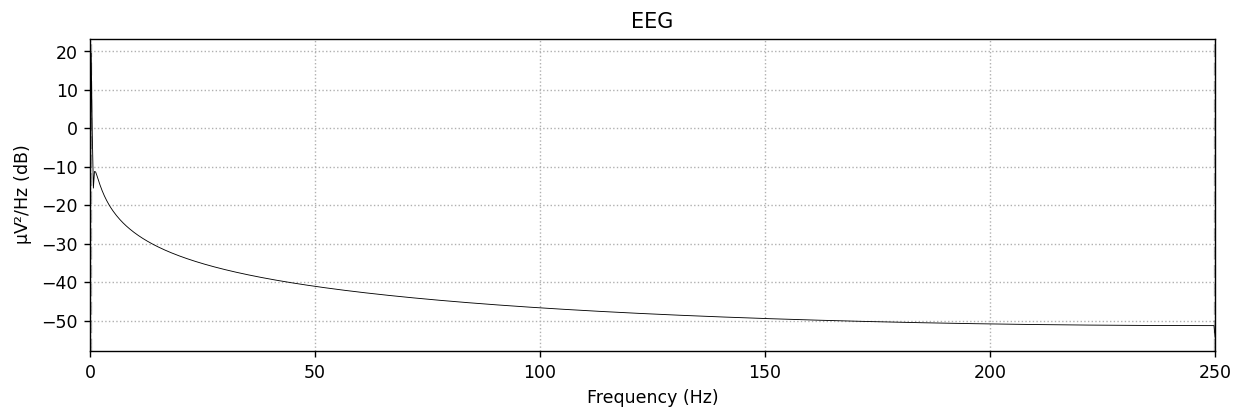

In [8]:
# Visualize the power spectrum of the data
(
    raw
    .copy()
    .pick(dataChannels)
    .compute_psd(fmax=raw.info["sfreq"] / 2)
    .plot(average=True)
)

In [9]:
# Apply necessary filtering. This may need to be changed for each session. Data
# must be loaded to apply filtering
raw_filtered = raw.copy()
raw_filtered.load_data()

# Apply notch filter to remove noise spikes
notch_freqs = CONFIG.notch_freqs
if notch_freqs is not None:
    raw_filtered.pick(dataChannels).notch_filter(freqs=notch_freqs)

# Apply bandpass filter to isolate relevant frequencies
l_freq = CONFIG.l_freq
h_freq = CONFIG.h_freq
if l_freq is not None or h_freq is not None:
    raw_filtered.pick(dataChannels).filter(l_freq, h_freq)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge

Effective window size : 4.096 (s)


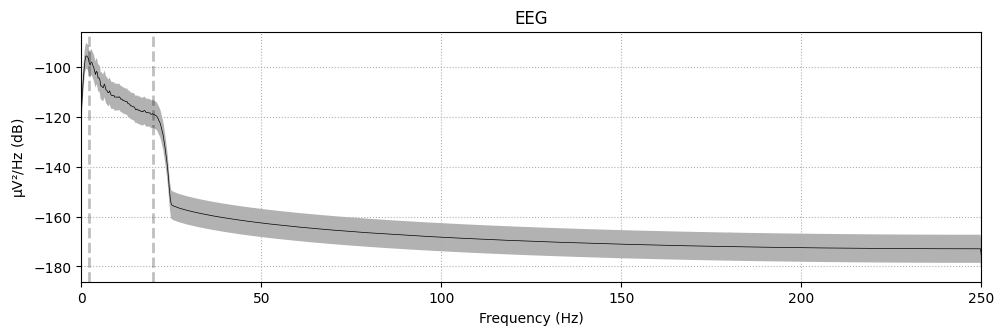

In [10]:
# Visualize the power spectrum of the filtered data
(
    raw_filtered
    .copy()
    .pick(dataChannels)
    .compute_psd(fmax=raw_filtered.info["sfreq"] / 2)
    .plot(average=True)
)

# Epoching
***

## Extract Metadata

In [11]:
# Specify parameters for extracting metadata
timeIntervalPadding = CONFIG.metadata_timeIntervalPadding
tmin = -1 * CONFIG.baseline_duration
tmax = CONFIG.stimulus_duration + CONFIG.break_duration
rowEvents = [x for x in eventDict if x.startswith("visual_stimulus_onset")]

timeIntervalPaddingDur = (tmax - tmin) * timeIntervalPadding / 2

In [12]:
# Extract the metadata and corresponding events and event IDs
metadata, events_md, eventDict_md = mne.epochs.make_metadata(
    events,
    eventDict,
    tmin - timeIntervalPaddingDur,
    tmax + timeIntervalPaddingDur,
    raw_filtered.info["sfreq"],
    row_events=rowEvents,
    keep_first=[
        "visual_stimulus_onset",
        "auditory_stimulus_onset",
        "response"
    ]
)

# Determine congruency
metadata["isCongruent"] = metadata["first_visual_stimulus_onset"].str.extract(
    r"(congruent|noncongruent)",
    expand=False
)

# Determine distractor presence
metadata["isDistractor"] = "nondistractor"
metadata.loc[
    metadata["auditory_stimulus_onset"].notna(),
    "isDistractor"
] = "distractor"

# Display the metadata
metadata

,event_name,OVTK_StimulationId_Number_1B,OVTK_StimulationId_ExperimentStart,OVTK_StimulationId_ExperimentStop,block_start/OVTK_StimulationId_SegmentStart,block_stop/OVTK_StimulationId_SegmentStop,visual_stimulus_end/OVTK_StimulationId_VisualStimulationStop,response/OVTK_StimulationId_Button1_Pressed,response/OVTK_StimulationId_Button2_Pressed,response/OVTK_StimulationId_Button3_Pressed,...,OVTK_GDF_Cross_On_Screen,OVTK_GDF_Incorrect,visual_stimulus_onset,auditory_stimulus_onset,response,first_visual_stimulus_onset,first_auditory_stimulus_onset,first_response,isCongruent,isDistractor
15,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,-1.508,NaN,2.000,0.846,NaN,NaN,...,-1.498,NaN,0.0,NaN,0.846,congruent/OVTK_StimulationId_Label_11,None,OVTK_StimulationId_Button1_Pressed,congruent,nondistractor
20,visual_stimulus_onset/noncongruent/OVTK_Stimul...,NaN,NaN,NaN,NaN,NaN,1.996,NaN,NaN,NaN,...,-1.494,NaN,0.0,NaN,0.932,noncongruent/OVTK_StimulationId_Label_24,None,OVTK_StimulationId_Button4_Pressed,noncongruent,nondistractor
25,visual_stimulus_onset/noncongruent/OVTK_Stimul...,NaN,NaN,NaN,NaN,NaN,2.004,NaN,1.182,NaN,...,-1.494,NaN,0.0,NaN,1.182,noncongruent/OVTK_StimulationId_Label_32,None,OVTK_StimulationId_Button2_Pressed,noncongruent,nondistractor
30,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,NaN,NaN,2.000,NaN,0.566,NaN,...,-1.492,NaN,0.0,NaN,0.566,congruent/OVTK_StimulationId_Label_22,None,OVTK_StimulationId_Button2_Pressed,congruent,nondistractor
35,visual_stimulus_onset/noncongruent/OVTK_Stimul...,NaN,NaN,NaN,NaN,NaN,2.000,0.756,NaN,NaN,...,-1.488,NaN,0.0,NaN,0.756,noncongruent/OVTK_StimulationId_Label_13,None,OVTK_StimulationId_Button1_Pressed,noncongruent,nondistractor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,visual_stimulus_onset/noncongruent/OVTK_Stimul...,NaN,NaN,NaN,NaN,NaN,2.004,0.718,NaN,NaN,...,-1.496,NaN,0.0,-1.516,0.718,noncongruent/OVTK_StimulationId_Label_21,OVTK_StimulationId_Label_D4,OVTK_StimulationId_Button1_Pressed,noncongruent,distractor
1437,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,NaN,NaN,1.994,NaN,1.174,NaN,...,-1.492,NaN,0.0,-1.510,1.174,congruent/OVTK_StimulationId_Label_22,OVTK_StimulationId_Label_D3,OVTK_StimulationId_Button2_Pressed,congruent,distractor
1447,visual_stimulus_onset/noncongruent/OVTK_Stimul...,NaN,NaN,NaN,NaN,NaN,2.002,NaN,NaN,0.632,...,-1.494,NaN,0.0,-1.514,0.632,noncongruent/OVTK_StimulationId_Label_43,OVTK_StimulationId_Label_D2,OVTK_StimulationId_Button3_Pressed,noncongruent,distractor
1457,visual_stimulus_onset/noncongruent/OVTK_Stimul...,NaN,NaN,NaN,NaN,NaN,1.998,NaN,NaN,NaN,...,-1.496,NaN,0.0,-1.512,0.754,noncongruent/OVTK_StimulationId_Label_14,OVTK_StimulationId_Label_D2,OVTK_StimulationId_Button4_Pressed,noncongruent,distractor


In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


stim_reaction_time_df = metadata[["isCongruent", "isDistractor","first_visual_stimulus_onset", "first_response", "response"]]
#perform two-way ANOVA
model = ols('response ~ C(isCongruent) + C(isDistractor) + C(isCongruent):C(isDistractor)', data=stim_reaction_time_df).fit()
sm.stats.anova_lm(model, typ=2)

# todo : save it to a csv 
# run spss

,sum_sq,df,F,PR(>F)
C(isCongruent),0.209785,1.0,3.387901,0.067261
C(isDistractor),0.079153,1.0,1.278270,0.259669
C(isCongruent):C(isDistractor),0.106628,1.0,1.721976,0.191047
Residual,11.579391,187.0,NaN,NaN


## Epoch Data

In [21]:
# Epoch the data using the metadata and corresponding events and event IDs
epochs = mne.Epochs(
    raw_filtered,
    events_md,
    event_id=eventDict_md,
    tmin=CONFIG.epoch_tmin,
    tmax=CONFIG.epoch_tmax,
    metadata=metadata,
    event_repeated='drop', # Preferrably don't drop, but sometimes necessary
    preload=True
)

#TODO: drop bad epochs

Adding metadata with 49 columns
192 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 192 events and 751 original time points ...


0 bad epochs dropped


# Visualizing ERP
***

In [15]:
# TODO: auomate conversion of channel numbers to channel names

# Specify parameters for visualizing the data
title = CONFIG.display_name
title = title + " - ERP" if title is not None else "ERP"

# Specify the colors to use for plotting each channel
cm = mpl.colormaps["viridis"].resampled(len(targetChannels))
colors = {chName : color for (chName, color) in zip(targetChannels, cm.colors)}

In [16]:
isCongruent, isDistractor = np.meshgrid(
    ["Congruent", "Noncongruent"], 
    ["Distractor", "Nondistractor"],
)
rows, cols = np.indices(isCongruent.shape)

fig = plt.figure(layout="constrained", figsize=[10,5])
axs = fig.subplots(len(cols), len(rows), sharex=True, sharey=True)

# Plot ERP for every combination of experimental conditions
for r, c in np.nditer([rows, cols]):
    
    # Select the subset of the epochs for this combination of experimental
    # conditions
    subset = epochs[
        f"isCongruent == '{isCongruent[r,c].lower()}'" +
        f"& isDistractor == '{isDistractor[r,c].lower()}'"
    ]
    
    # Average target channels over epochs
    evoked = subset.copy().pick(targetChannels).average()
    
    # Plot the ERP
    processing.prettyPlotEvoked(evoked, ax=axs[r,c], colors=colors, units="V")
    
    # Add lines at y=0 and x=0
    axs[r,c].axhline(0, ls="dotted", lw=0.75, color="gray")
    axs[r,c].axvline(0, ls=(0, (10, 10)), lw=0.75, color="gray")
    
    # Clean up the figure
    # Handle axis labels
    isLastRow = (r == np.max(rows))
    isFirstCol = (c == np.min(cols))
    if isLastRow and isFirstCol:
        # Move axis labels to spread over all rows/columns
        fig.supxlabel(axs[r,c].get_xlabel())
        fig.supylabel(axs[r,c].get_ylabel())
    # Label the experimental conditions corresponding to each row/column
    axs[r,c].set_xlabel(isCongruent[r,c] if isLastRow else None)
    axs[r,c].set_ylabel(isDistractor[r,c] if isFirstCol else None)
    # Remove title of every plot
    axs[r,c].set_title(None)
    
fig.suptitle(title)
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right center")
plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [17]:
# Save the figure and the config values used in this analysis to a file.
# Assume they have not been changed since starting the analysis

date = datetime.now().strftime("%Y-%m-%d_%H%M%S")
dName = os.path.join(sessionDir, "analysis")
os.makedirs(dName, exist_ok=True)

fName_figure = os.path.join(dName, "erp_" + date + ".png")
plt.savefig(fName_figure, dpi=512)

fName_config = os.path.join(dName, "config_" + date + ".yaml")
with open(fName_config, "x") as f:
    yaml.dump(CONFIG.snapshot(), f)

stim_reaction_time_df.to_excel(dName+"_behavioural.xlsx", index= False)  


Channels marked as bad:
none
